In [2]:
import torch 
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt

# Sample Code 

Here, we wish to solve a (scalar) regression problem. The following code is a simple implementation of Gaussian process using RF kernel. Here, $\{(x_i, y_i)\}_{i = 1}^N$ is generated a priori, and we will infer $f_\theta(\cdot) : \mathbb{R} \rightarrow \mathbb{R}$ such that $f_\theta(x) \simeq f_{\mathrm{true}}(x)$. 

For details regarding the RBF kernel and Gaussian process, please refer to my slide. 

In [3]:
def f_true(x) : 
    '''
    Our true function. We wish to approximate this function via kernel method.
    '''
    return (x - 2) * np.cos(4 * x)


def kernel(x, y, theta) : 
    '''
    Our kernel function. We wish to solve a regression problem with the kernel function. 
    '''
    return theta[0] * torch.exp((-theta[1] / 2) * (x - y )** 2) + theta[2] + theta[3] * x.T * y



##############################
## STEP 1 : Data Generation ##
##############################

N = 100
X = np.random.normal(loc = 0.0, scale = 1, size = N)
Y = f_true(X)
T = Y + np.random.normal(loc = 0.0, scale = 0.05, size = N)     # random error

X = torch.Tensor(X)
T = torch.Tensor(T)
EPOCH = 200

##############################
## STEP 2 : Define a model  ##
##############################


class GaussianKernelRegression(nn.Module) : 
    """
    A nn.Module object that serves as our model based on Gaussian Kernel.
    Here, we solve a 1-dimensional regression problem (functional approximation). 
    """
    
    def __init__(self, observed_X, observed_T, kernel_function = kernel, alpha = 0.5, beta = 0.6) : 
        super().__init__()
        # Inputs and observations 
        self.X = observed_X
        self.N = self.X.shape[0]
        self.t = observed_T
        
        # Hyperparameters
        self.alpha = alpha 
        self.beta = beta 
        
        # Model, parameters and optimizer
        self.kernel = kernel_function   
        self.theta = torch.randn(4, requires_grad = True)   # optimization variable
        self.optimizer = torch.optim.SGD([self.theta], lr = 0.001)
    
    
    
    def logProb(self) : 
        """
        This function calculates the log-posterior of t = (t_1, \cdots, t_N). 
        We will use this function as a loss function.
        """
        C = self.Cov()
        loss = +0.5 * torch.log(torch.abs(torch.det(C))) + 0.5 * self.t.T @ torch.linalg.inv(C) @ self.t 
        return loss.requires_grad_(True)
    
    
    def Gram(self) : 
        '''
        This function calculates the gram matrix given the data and parameter. 
        '''
        X = self.X
        N = self.N
        G = torch.zeros((N, N))
        for i in range(N) :
            for j in range(N) : 
                G[i, j] += self.kernel(X[i], X[j], self.theta)
    
        self.G = G.requires_grad_(True)
        return self.G

    
    def Cov(self) : 
        '''
        This function calculates the C_N matrix according to self.theta (parameter) value.
        '''
        C = self.Gram() + (1 / self.beta) * torch.eye(self.N)
        self.C = C.requires_grad_(True)
        self.C_inv = torch.linalg.inv(C).requires_grad_(True)
        return self.C
    
    
    def forward(self, x) : 
        '''
        This function calculates the predicted value that corresponds to the given scalar input x.
        Here, x is not observed. 
        '''
        X = self.X
        lambda_ = torch.Tensor([self.kernel(X[i], x, self.theta) for i in range(N)])
        return lambda_.T @ self.C_inv @ self.t
    
    
    def optimize_parameters(self) : 
        self.optimizer.zero_grad()
        log_likelihood = self.logProb()
        log_likelihood.requires_grad_(True)
        print(f" === [Epoch {self.epoch + 1}] === Loss : {log_likelihood}")
        self.theta.retain_grad()
        log_likelihood.backward()
        self.optimizer.step()
        
    
    
    def train(self) : 
        self.epoch = 0 
        for i in range(EPOCH) : 
            self.optimize_parameters()
            self.epoch += 1
        
    
    def test(self) : 
        X = torch.linspace(start = -1, end = 1, steps = 100)
        Y_true = f_true(X.numpy())
        Predict = torch.zeros_like(X)
        for i in range(100) : 
            Predict[i] = self.forward(X[i])
        return X, Y_true, Predict

In [4]:
m = GaussianKernelRegression(X, T)

In [6]:
m.Gram()  # Gram matrix must be a symmetric PSD. (Check it out!) 

tensor([[ 1.2451, -1.2395,  0.8949,  ...,  1.3763,  1.2609,  0.7643],
        [-1.2395,  3.9836, -0.5579,  ..., -1.6567, -1.2805, -0.3521],
        [ 0.8949, -0.5579,  0.8522,  ...,  0.8584,  0.8929,  0.8066],
        ...,
        [ 1.3763, -1.6567,  0.8584,  ...,  1.6271,  1.4037,  0.6908],
        [ 1.2609, -1.2805,  0.8929,  ...,  1.4037,  1.2778,  0.7580],
        [ 0.7643, -0.3521,  0.8066,  ...,  0.6908,  0.7580,  0.7892]],
       grad_fn=<CopySlices>)

In [ ]:
m.train() # I have deleted the cell output because it is too long. 

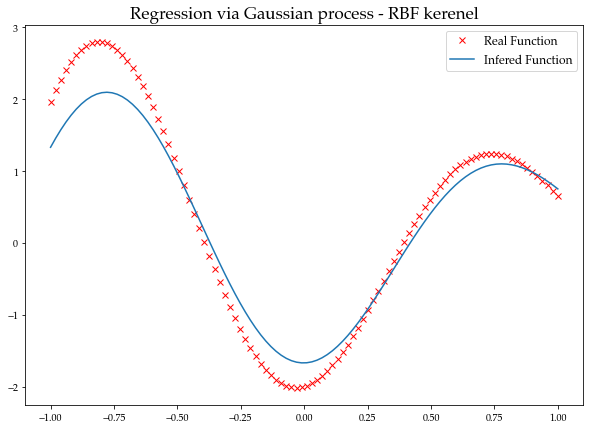

In [24]:
# We plot our result to see if the regression process is successfully solved. 
plt.figure(figsize = (10, 7))
plt.plot(X, Y_true, 'rx', label ='Real Function')
plt.plot(X, Predict.detach().numpy(), label = 'Infered Function')
plt.legend(fontsize = 12)
plt.title("Regression via Gaussian process - RBF kerenel", fontsize = 17)
plt.show()